# Predicting Movie Success/Flop using Movie Attributes and Social Media Data

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from easymoney.money import EasyPeasy
import warnings
warnings.filterwarnings('ignore')
import random

## Importing Models

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

## Splitting Dataset into train and test
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Define class weights
from sklearn.utils import class_weight

## For Feature Selection
from sklearn.feature_selection import RFE
# Extracting using ANOVA F-values
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

## For confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
# Function to plot confusion matrix
def plot_confusion(y_test, pred): 
    cm = confusion_matrix(y_test, pred)

    ax = plt.subplot()
    sns.heatmap(cm, 
                annot=True, fmt='g', cmap='Greens',
                ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(['Success', 'Flop'])
    ax.yaxis.set_ticklabels(['Success', 'Flop'])
    plt.show()

### Import Data

In [3]:
#Importing movies
movies = pd.read_csv('/home/jovyan/git/lf_capstone/utils/clusters.csv')

#Import Facebook rollup data
fb_rollup1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_facebook_1k-10k.tsv', delimiter='\t')
fb_rollup2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_facebook_10kplus.tsv', delimiter='\t')
#Combine Facebook data
fb = pd.concat([fb_rollup1, fb_rollup2])

#Import Twitter rollup data
twitter_rollup1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_twitter_1k-10k.tsv', delimiter='\t')
twitter_rollup2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_twitter_10kplus.tsv', delimiter='\t')
#Combine Twitter data
twitter = pd.concat([twitter_rollup1, twitter_rollup2])

#Import Instagram rollup data
insta_rollup1 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_instagram_1k-10k.tsv', delimiter='\t')
insta_rollup2 = pd.read_csv('/home/jovyan/capstone_data/listenfirst/data/view_brand_rollup_instagram_10kplus.tsv', delimiter='\t')
#Combine Instagram data
instagram = pd.concat([insta_rollup1, insta_rollup2])

In [4]:
#Define flop as when box office is less than budget
movies['flop'] = np.where(movies['DomesticGross']<movies['budget'], 1, 0)

#Select columns from movie DataFrame
movies_fil = movies[['brand_ods_id', 'replace', 'released_on', 'released_year', 'year_bin',
       'production_company', 'rating', 'source', 'franchise',
       'genre_grouped', 'inflated_budget', 'inflated_boxoffice', 'production_company_bin', 'flop']]

#Converting date column to date time
movies_fil['released_on'] = pd.to_datetime(movies_fil['released_on'])
#Extract months from date
movies_fil['released_month'] = movies_fil['released_on'].map(lambda x: x.month)
#Extract inflated profit
movies_fil['inflated_profit'] = movies_fil['inflated_boxoffice'] - movies_fil['inflated_budget']
#Place profit into bins
movies_fil['profit_bins'] = pd.qcut(movies_fil['inflated_profit'],  q= 3,
                             labels=['Flop', 'Medium Profit', 'Insane Profit'])


### Aggregating Social Media Data from 1 year to 3 months before release

In [5]:
#Modify column title
fb.columns = ['movie_id', 'data_for'] + [str(col) + '_facebook' for col in fb.columns[2:]]
#Merge social media data with movie data
fb_merged = pd.merge(fb, movies_fil, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
fb_dropped = fb_merged.dropna(subset=['replace'])
fb_dropped['data_for']= pd.to_datetime(fb_dropped['data_for']) 
fb_dropped['released_on'] = pd.to_datetime(fb_dropped['released_on'])
fb_dropped['days_after_release'] = fb_dropped['data_for'] - fb_dropped['released_on'] 
#Limit data from 1 year to 3 months 
fb_fil = fb_dropped[(fb_dropped['days_after_release'] <= '-90 days') & (fb_dropped['days_after_release'] >= '-365 days')]

#Obtain the mean of each feature
fb_grouped = fb_fil.groupby('movie_id', as_index = False).agg('mean')
#Drop repeated columns
fb_grouped = fb_grouped.drop(['brand_ods_id',
       'released_year', 'year_bin', 'inflated_budget', 'inflated_boxoffice',
       'released_month', 'inflated_profit', 'flop'], axis = 1)

In [6]:
#Modify column title
twitter.columns = ['movie_id', 'data_for'] + [str(col) + '_twitter' for col in twitter.columns[2:]]
#Merge social media data with movie data
twitter_merged = pd.merge(twitter, movies_fil, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
twitter_dropped = twitter_merged.dropna(subset=['replace'])
twitter_dropped['data_for']= pd.to_datetime(twitter_dropped['data_for']) 
twitter_dropped['released_on'] = pd.to_datetime(twitter_dropped['released_on'])
twitter_dropped['days_after_release'] = twitter_dropped['data_for'] - twitter_dropped['released_on']
#Limit data from 1 year to 3 months 
twitter_fil = twitter_dropped[(twitter_dropped['days_after_release'] <= '-90 days') & (twitter_dropped['days_after_release'] >= '-365 days')]

#Obtain the mean of each feature
twitter_grouped = twitter_fil.groupby('movie_id', as_index = False).agg('mean')
#Drop repeated columns
twitter_grouped = twitter_grouped.drop(['brand_ods_id',
       'released_year', 'year_bin', 'inflated_budget', 'inflated_boxoffice',
       'released_month', 'inflated_profit', 'flop'], axis = 1 )

In [7]:
#Modify column title
instagram.columns = ['movie_id', 'data_for'] + [str(col) + '_instagram' for col in instagram.columns[2:]]
#Merge social media data with movie data
instagram_merged = pd.merge(instagram, movies_fil, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
instagram_dropped = instagram_merged.dropna(subset=['replace'])
instagram_dropped['data_for']= pd.to_datetime(instagram_dropped['data_for']) 
instagram_dropped['released_on'] = pd.to_datetime(instagram_dropped['released_on'])
instagram_dropped['days_after_release'] = instagram_dropped['data_for'] - instagram_dropped['released_on'] 
#Limit data from 1 year to 3 months 
instagram_fil = instagram_dropped[(instagram_dropped['days_after_release'] <= '-90 days') & (instagram_dropped['days_after_release'] >= '-365 days')]

#Obtain the mean of each feature
instagram_grouped = instagram_fil.groupby('movie_id', as_index = False).agg('mean')
#Drop repeated columns
instagram_grouped = instagram_grouped.drop(['brand_ods_id',
       'released_year', 'year_bin', 'inflated_budget', 'inflated_boxoffice',
       'released_month', 'inflated_profit', 'flop'], axis = 1)

### Merging Movie attribute data with social media data

In [8]:
movies_fil = pd.merge(movies_fil, fb_grouped, left_on = 'brand_ods_id', right_on = 'movie_id', how = 'left')
movies_fil = pd.merge(movies_fil, twitter_grouped, left_on = 'movie_id', right_on = 'movie_id', how = 'left')
movies_fil = pd.merge(movies_fil, instagram_grouped, left_on = 'movie_id', right_on = 'movie_id', how = 'left')


In [9]:
# Fill NAN cells with 0
movies_fil.update(movies_fil[['likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram']].fillna(0))

### Preparing DataFrames for Models

In [10]:
#Defining Dataframe with Movie Attributes and Social Media Data (movies_test)
movies_test = movies_fil[['rating', 'source', 'franchise', 'genre_grouped',
       'inflated_budget', 'production_company_bin',
       'released_month', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram',  'flop']]

#Defining Dataframe with only Budget and Social Media Data (movies_num)
movies_num = movies_fil[['inflated_budget', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram',  'flop']]

#Movies with no daily data
movies_nodailys = movies_num[['inflated_budget', 'likes_facebook', 'talking_about_facebook',
        'engagement_rate_facebook','total_post_facebook',
              'total_post_likes_facebook','total_post_shares_facebook',
        'total_post_comments_facebook', 'total_post_love_count_facebook',
        'total_post_wow_count_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_facebook','total_post_angry_count_facebook',
       'total_post_thankful_count_facebook',
       'total_post_video_facebook', 
       'total_post_video_interactions_facebook', 
       'tweets_twitter',  'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_twitter', 'total_favorites_twitter',
       'total_replies_twitter', 'tracked_posts_twitter',
              'video_tracked_posts_twitter','video_retweets_twitter',
        'video_favorites_twitter', 'video_replies_twitter',
        'video_views_twitter', 
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
        'media_count_instagram','tracked_posts_instagram',
       'followed_by_count_instagram', 'follows_count_instagram',
       'total_likes_instagram', 'total_comments_instagram',
       'avg_interactions_per_post_instagram', 'flop']]

In [11]:
# Encoding Categorical variables in movies_test
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 

movies_test["rating"] = movies_test["rating"].astype('category')
movies_test["source"] = movies_test["source"].astype('category')
movies_test["franchise"] = movies_test["franchise"].astype('category')
movies_test["genre_grouped"] = movies_test["genre_grouped"].astype('category')
movies_test["production_company_bin"] = movies_test["production_company_bin"].astype('category')
movies_test["released_month"] = movies_test["released_month"].astype('category')
movies_test["flop"] = movies_test["flop"].astype('category')


movies_test["rating"] = le.fit_transform(movies_test["rating"])
movies_test["source"] = le.fit_transform(movies_test["source"])
movies_test["franchise"] = le.fit_transform(movies_test["franchise"])
movies_test["genre_grouped"] = le.fit_transform(movies_test["genre_grouped"])
movies_test["production_company_bin"] = le.fit_transform(movies_test["production_company_bin"])
movies_test["released_month"] = le.fit_transform(movies_test["released_month"])
movies_test["flop"] = le.fit_transform(movies_test["flop"])

movies_num["flop"] = movies_num["flop"].astype('category')
movies_num["flop"] = le.fit_transform(movies_num["flop"])

## Feature Selection

### KS Score

In [12]:
#Defining function for calculating KS Score for each feature
from scipy import stats
def ks_score(df, label_col, pos_lab, neg_lab):
    columns = [x for x in df.columns[2:]]
    stat = [stats.ks_2samp(df[df[label_col] == pos_lab][x], df[df[label_col] == neg_lab][x])[0] for x in df.columns[2:]]
    pvalue = [stats.ks_2samp(df[df[label_col] == pos_lab][x], df[df[label_col] == neg_lab][x])[1] for x in df.columns[2:]]
    ks_df = pd.DataFrame(list(zip(columns,stat, pvalue)), columns =['variable', 'ks_stat', 'p_value'])
    return(ks_df)

In [13]:
#Selecting features for movies
movies_sel = movies_fil[['brand_ods_id', 'rating', 'source', 'franchise', 'genre_grouped',
       'inflated_budget', 'production_company_bin',
       'released_month', 'released_on', 'flop']]


#### Facebook features

In [14]:
#Fill na with 0
fb_filled = fb.fillna(0)

#Merge facebook data with selected features
fb_output = pd.merge(fb_filled, movies_sel, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
#Clean up data
fb_output = fb_output.dropna(subset=['brand_ods_id'])
fb_output['data_for']= pd.to_datetime(fb_output['data_for']) 
fb_output['released_on'] = pd.to_datetime(fb_output['released_on'])
fb_output['days_after_release'] = fb_output['data_for'] - fb_output['released_on']
#Limit from a year before release to release
fb_output = fb_output[(fb_output['days_after_release'] <= '0 days') & (fb_output['days_after_release'] >= '-365 days')]
fb_output['days_after_release'] = fb_output['days_after_release'].dt.days

#Output if necessary
fb_output.to_csv('toby_test.csv')

In [15]:
#Calculate mean for each feature
fb_mean = fb_output.groupby(['flop','days_after_release'], as_index = False).agg('mean').drop(
    ['movie_id', 'brand_ods_id',
       'inflated_budget', 'released_month'], axis=1)

In [16]:
#Calculate KS Score for each feature
fb_var_score = ks_score(fb_mean, 'flop', 0, 1)
fb_var_score.sort_values('ks_stat', ascending = False).head(5)

,variable,ks_stat,p_value
19,total_post_haha_count_facebook,0.969945,2.255353e-195
25,total_post_thankful_count_facebook,0.928962,1.425953e-171
21,total_post_sad_count_facebook,0.778689,5.531181e-110
23,total_post_angry_count_facebook,0.661202,4.968030e-76
33,total_post_video_facebook,0.653005,5.554754e-74


#### Instagram features

In [17]:
insta_filled = instagram.fillna(0)

insta_output = pd.merge(insta_filled, movies_sel, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
insta_output = insta_output.dropna(subset=['brand_ods_id'])
insta_output['data_for']= pd.to_datetime(insta_output['data_for']) 
insta_output['released_on'] = pd.to_datetime(insta_output['released_on'])
insta_output['days_after_release'] = insta_output['data_for'] - insta_output['released_on']
insta_output = insta_output[(insta_output['days_after_release'] <= '0 days') & (insta_output['days_after_release'] >= '-365 days')]
insta_output['days_after_release'] = insta_output['days_after_release'].dt.days

In [18]:
insta_mean = insta_output.groupby(['flop','days_after_release'], as_index = False).agg('mean').drop(
    ['movie_id', 'brand_ods_id',
       'inflated_budget', 'released_month'], axis=1)


In [19]:
insta_var_score = ks_score(insta_mean, 'flop', 0, 1)
insta_var_score.sort_values('ks_stat', ascending = False).head(5)

,variable,ks_stat,p_value
3,tracked_posts_instagram,0.693989,1.307407e-84
15,avg_interactions_per_post_instagram,0.606557,4.683969e-63
11,total_comments_instagram,0.478142,3.078918e-38
5,followed_by_count_instagram,0.437158,8.318472e-32
9,total_likes_instagram,0.390710,2.592883e-25


#### Twitter features

In [20]:
twitter_filled = twitter.fillna(0)

twitter_output = pd.merge(twitter_filled, movies_sel, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')
twitter_output = twitter_output.dropna(subset=['brand_ods_id'])
twitter_output['data_for']= pd.to_datetime(insta_output['data_for']) 
twitter_output['released_on'] = pd.to_datetime(insta_output['released_on'])
twitter_output['days_after_release'] = twitter_output['data_for'] - twitter_output['released_on']
twitter_output = twitter_output[(twitter_output['days_after_release'] <= '0 days') & (twitter_output['days_after_release'] >= '-365 days')]
twitter_output['days_after_release'] = twitter_output['days_after_release'].dt.days

In [21]:
twitter_mean = twitter_output.groupby(['flop','days_after_release'], as_index = False).agg('mean').drop(
    ['movie_id', 'brand_ods_id',
       'inflated_budget', 'released_month'], axis=1)

In [22]:
twitter_var_score = ks_score(twitter_mean, 'flop', 0, 1)
twitter_var_score.sort_values('ks_stat', ascending = False).head(5)

,variable,ks_stat,p_value
25,total_post_interactions_twitter,1.000000,3.002873e-219
7,total_retweets_twitter,1.000000,3.002873e-219
9,total_favorites_twitter,1.000000,3.002873e-219
19,video_favorites_twitter,0.989071,3.562908e-209
23,video_views_twitter,0.967213,1.355091e-193


### Recursive Feature Selection

#### Extract top 10 most important features for only Numerical non-daily Data using RFE on Logistic Regression

In [23]:
X = movies_nodailys.iloc[:,0:40]  #feature columns
y = movies_nodailys.iloc[:,-1]    #label columns

logreg = LogisticRegression()
rfe = RFE(logreg, 10)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False  True  True
  True False False False  True False  True False False False  True False
 False  True  True False False False False False  True False False False
 False False False  True]
[29 11  2 21 22 16 26  6 10  7  1  1  1 20 24 15  1  9  1 12  4  5  1 19
 28  1  1  8 17 13 30 31  1 23 25 14 27 18  3  1]


In [24]:
X.iloc[:,rfe.support_].columns

Index(['total_post_haha_count_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_facebook', 'tweets_twitter', 'mentions_twitter',
       'total_replies_twitter', 'video_retweets_twitter',
       'video_favorites_twitter', 'avg_tweet_interaction_twitter',
       'avg_interactions_per_post_instagram'],
      dtype='object')

### ANOVA Feature Selection

#### Extract top 10 most important features using ANOVA F-values for only Numerical Data

In [25]:
X = movies_num.iloc[:,0:83]  #feature columns
y = movies_num.iloc[:,-1]    #label columns

#Use SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
0                       inflated_budget  11.462188
6              engagement_rate_facebook   5.113846
13       total_post_comments_c_facebook   4.612369
4                talking_about_facebook   4.411654
19     total_post_haha_count_c_facebook   4.197652
63               hashtag_volume_twitter   3.727697
20       total_post_haha_count_facebook   3.567488
82  avg_interactions_per_post_instagram   3.411054
66        avg_tweet_interaction_twitter   3.078835
42               total_mentions_twitter   2.932232


#### Extract top 10 most important features using ANOVA F-values for only Numerical non-daily Data

In [26]:
# Extracting using ANOVA F-values

X = movies_nodailys.iloc[:,0:40]  #feature columns
y = movies_nodailys.iloc[:,-1]    #label columns

#Use SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
0                       inflated_budget  11.462188
3              engagement_rate_facebook   5.113846
2                talking_about_facebook   4.411654
29               hashtag_volume_twitter   3.727697
10       total_post_haha_count_facebook   3.567488
39  avg_interactions_per_post_instagram   3.411054
32        avg_tweet_interaction_twitter   3.078835
19               total_mentions_twitter   2.932232
27                video_replies_twitter   2.248467
18                     mentions_twitter   1.794742


#### Extract top 10 most important features for only Numerical non-daily Data and categorical data

In [27]:
movies_nodailys_cat = movies_test[['rating', 'source', 'franchise', 'genre_grouped', 'production_company_bin',
       'released_month', 'inflated_budget', 'likes_facebook', 'talking_about_facebook',
        'engagement_rate_facebook','total_post_facebook',
              'total_post_likes_facebook','total_post_shares_facebook',
        'total_post_comments_facebook', 'total_post_love_count_facebook',
        'total_post_wow_count_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_facebook','total_post_angry_count_facebook',
       'total_post_thankful_count_facebook',
       'total_post_video_facebook', 
       'total_post_video_interactions_facebook', 
       'tweets_twitter',  'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_twitter', 'total_favorites_twitter',
       'total_replies_twitter', 'tracked_posts_twitter',
              'video_tracked_posts_twitter','video_retweets_twitter',
        'video_favorites_twitter', 'video_replies_twitter',
        'video_views_twitter', 
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
        'media_count_instagram','tracked_posts_instagram',
       'followed_by_count_instagram', 'follows_count_instagram',
       'total_likes_instagram', 'total_comments_instagram',
       'avg_interactions_per_post_instagram', 'flop']]

In [28]:
# Extracting using ANOVA F-values
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X = movies_nodailys_cat.iloc[:,0:46]  #feature columns
y = movies_nodailys_cat.iloc[:,-1]    #label columns

#Use SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                  Specs      Score
6                       inflated_budget  11.462188
1                                source   7.524014
9              engagement_rate_facebook   5.113846
8                talking_about_facebook   4.411654
2                             franchise   4.006687
35               hashtag_volume_twitter   3.727697
16       total_post_haha_count_facebook   3.567488
45  avg_interactions_per_post_instagram   3.411054
38        avg_tweet_interaction_twitter   3.078835
25               total_mentions_twitter   2.932232


## Finding the best balanced Model

### Trying different feature selection sets

In [29]:
#ANOVA of numerical with no daily
movies_attempt = movies_num[['inflated_budget',
              'engagement_rate_facebook',  
                'hashtag_volume_twitter',
  'avg_interactions_per_post_instagram',
            'total_post_haha_count_facebook',
               'total_mentions_twitter', 
      'avg_tweet_interaction_twitter',
                 'video_replies_twitter',
                     'mentions_twitter', 'flop']]


In [30]:
#ANOVA of numerical and categorical with daily
movies_attempt = movies_test[['inflated_budget',
                              'source',
       'total_post_comments_c_facebook',
     'total_post_haha_count_c_facebook',
                'talking_about_facebook',
              'engagement_rate_facebook',
               'hashtag_volume_twitter',
  'avg_interactions_per_post_instagram',
       'total_post_haha_count_facebook',
               'franchise',
                'flop']]


In [31]:
## Features selected through ANOVA for numerical non-daily data and categorical data 
## seemed to have the best performance
movies_attempt = movies_test[['inflated_budget', 'source',
            'engagement_rate_facebook', 'talking_about_facebook',
                           'franchise', 'hashtag_volume_twitter',
      'total_post_haha_count_facebook', 'avg_interactions_per_post_instagram',
       'avg_tweet_interaction_twitter',  'total_mentions_twitter',
                              'flop']]

### Without Normalizing

In [32]:
# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_attempt.loc[:,movies_attempt.columns != 'flop'], movies_attempt[['flop']], random_state=1234, test_size=0.20, shuffle=True)

In [33]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train), np.ravel(y_train))
class_weights = {0:class_weights[0], 1: class_weights[1]}

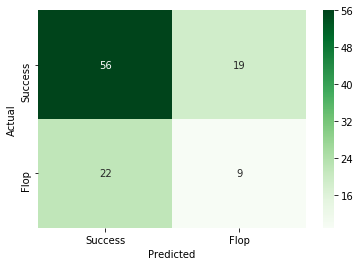

In [34]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0, class_weight = class_weights)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)     
logistic_AUC = metrics.roc_auc_score(y_test, predicted)       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(LogisticRegression(), x_train, y_train, scoring='balanced_accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)
plot_confusion(y_test, predicted)

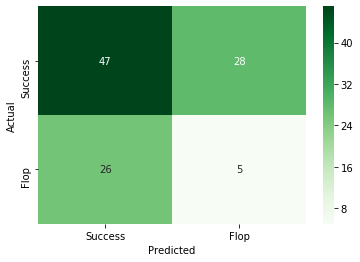

In [35]:
# Initiate Model

SGD_model = SGDClassifier(class_weight= class_weights)

# Model Fitting on Training
SGD_model = SGD_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(SGD_model.predict(x_test))

SGD_acc = metrics.accuracy_score(y_test, predicted)     
SGD_AUC = metrics.roc_auc_score(y_test, predicted)       
SGD_confusion = metrics.confusion_matrix(y_test, predicted) 
SGD_class_report = metrics.classification_report(y_test, predicted)
SGD_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
SGD_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
SGD_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
SGD_cv_scores = cross_val_score(SGD_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
SGD_cv_mean = np.mean(SGD_cv_scores)
plot_confusion(y_test, predicted)

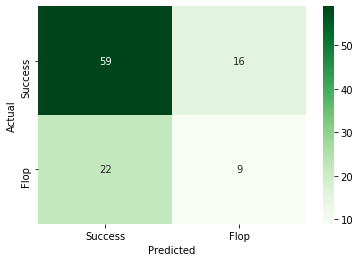

In [36]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=3) 

# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted)     
dtree_AUC = metrics.roc_auc_score(y_test, predicted)       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(tree.DecisionTreeClassifier(max_depth=3), x_train, y_train, scoring='balanced_accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)
plot_confusion(y_test, predicted)

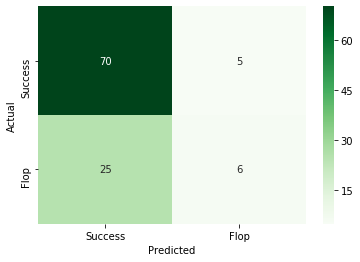

In [37]:
# Initiate Model
rf_model = RandomForestClassifier() 

# Model Fitting on Training
rf_model = rf_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)     
rf_AUC = metrics.roc_auc_score(y_test, predicted)       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(), x_train, y_train, scoring='balanced_accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)
plot_confusion(y_test, predicted)

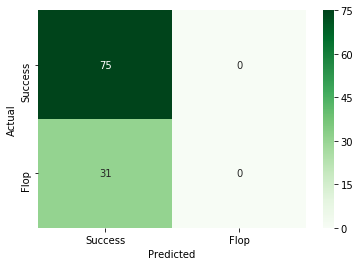

In [38]:
# Initiate Model

svm_class_model = SVC(probability=True)

# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

svm_class_acc = metrics.accuracy_score(y_test, predicted)     
svm_class_AUC = metrics.roc_auc_score(y_test, predicted)       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_train, y_train, scoring='balanced_accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)
plot_confusion(y_test, predicted)

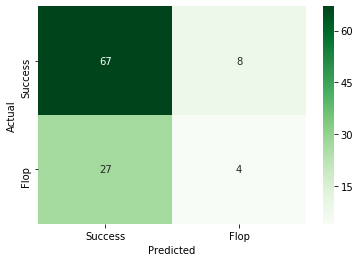

In [39]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Fitting on Training
knn_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)     
knn_AUC = metrics.roc_auc_score(y_test, predicted)       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_train, y_train, scoring='balanced_accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
plot_confusion(y_test, predicted)

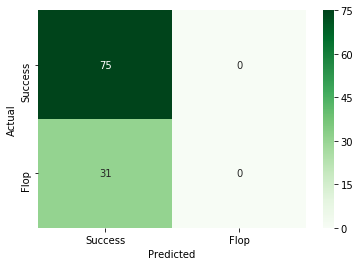

In [40]:
# Instantiate
mlp_model = MLPClassifier(hidden_layer_sizes=(15,5,1), random_state = 1234)
# Fit the model
mlp_model.fit(x_train, y_train)
# Accuracy
mlp_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(mlp_model.predict(x_test))
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)     
mlp_AUC = metrics.roc_auc_score(y_test, predicted)       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
plot_confusion(y_test, predicted)

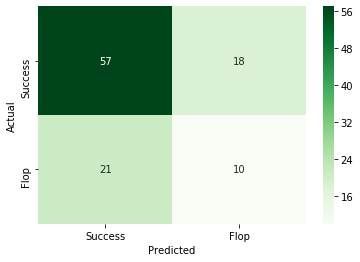

In [41]:
# Initiate Model
GBT_model = GradientBoostingClassifier(n_estimators=140, max_depth=14, learning_rate = 0.2, random_state = 1234)

# Model Fitting on Training
GBT_model = GBT_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(GBT_model.predict(x_test))
probs = pd.DataFrame(GBT_model.predict_proba(x_test))

GBT_acc = metrics.accuracy_score(y_test, predicted)
GBT_bal_acc = metrics.balanced_accuracy_score(y_test,predicted)
GBT_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
GBT_confusion = metrics.confusion_matrix(y_test, predicted) 
GBT_class_report = metrics.classification_report(y_test, predicted)
GBT_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
GBT_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
GBT_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
GBT_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
GBT_cv_scores = cross_val_score(GBT_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
GBT_cv_mean = np.mean(GBT_cv_scores)
#print(GBT_cv_mean)
plot_confusion(y_test, predicted)

In [42]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP', 'SGD', 'GBT'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc, SGD_acc, GBT_acc],
  'AUC' : [logistic_AUC, dtree_AUC, rf_AUC, svm_class_AUC, knn_AUC, mlp_AUC, SGD_AUC, GBT_AUC],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score, SGD_precision_score, GBT_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score, SGD_recall_score, GBT_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score, SGD_f1_score, GBT_f1_score],
  'cv_AUC' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean, SGD_cv_mean, GBT_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_AUC', ascending=False)

,Model,Accuracy,AUC,Precision,recall,F1,cv_AUC
7,GBT,0.632075,0.541290,0.357143,0.322581,0.338983,0.597056
2,r.f.,0.716981,0.563441,0.545455,0.193548,0.285714,0.571561
1,d.Tree,0.641509,0.538495,0.360000,0.290323,0.321429,0.545495
0,Logistic,0.613208,0.518495,0.321429,0.290323,0.305085,0.520245
6,SGD,0.490566,0.393978,0.151515,0.161290,0.156250,0.517098
3,SVM,0.707547,0.500000,0.000000,0.000000,0.000000,0.500000
5,MLP,0.707547,0.500000,0.000000,0.000000,0.000000,0.500000
4,kNN,0.669811,0.511183,0.333333,0.129032,0.186047,0.472929


### Results after Normalizing

In [43]:
## Creating a copy of only numerical data and then normalizing it
movies_num_normalize = movies_num.copy()

num_cols = ['inflated_budget', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram']


# apply standardization on numerical features
    
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(movies_num_normalize[[i]])
    
    # transform the training data column
    movies_num_normalize[i] = scale.transform(movies_num_normalize[[i]])
    
    # transform the testing data column
    movies_num_normalize[i] = scale.transform(movies_num_normalize[[i]])

In [44]:
## Creating a copy of normalized only numerical data with no daily data
movies_nodailys_normalize = movies_num_normalize[['inflated_budget', 'likes_facebook', 'talking_about_facebook',
        'engagement_rate_facebook','total_post_facebook',
              'total_post_likes_facebook','total_post_shares_facebook',
        'total_post_comments_facebook', 'total_post_love_count_facebook',
        'total_post_wow_count_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_facebook','total_post_angry_count_facebook',
       'total_post_thankful_count_facebook',
       'total_post_video_facebook', 
       'total_post_video_interactions_facebook', 
       'tweets_twitter',  'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_twitter', 'total_favorites_twitter',
       'total_replies_twitter', 'tracked_posts_twitter',
              'video_tracked_posts_twitter','video_retweets_twitter',
        'video_favorites_twitter', 'video_replies_twitter',
        'video_views_twitter', 
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
        'media_count_instagram','tracked_posts_instagram',
       'followed_by_count_instagram', 'follows_count_instagram',
       'total_likes_instagram', 'total_comments_instagram',
       'avg_interactions_per_post_instagram', 'flop']]

In [45]:
## Creating a copy of numerical and categorical then normalizing the numerical
movies_test_normalize = movies_test.copy()

num_cols = ['inflated_budget', 'likes_c_facebook', 'likes_facebook',
       'talking_about_c_facebook', 'talking_about_facebook',
       'engagement_rate_c_facebook', 'engagement_rate_facebook',
       'total_post_c_facebook', 'total_post_facebook',
       'total_post_likes_c_facebook', 'total_post_likes_facebook',
       'total_post_shares_c_facebook', 'total_post_shares_facebook',
       'total_post_comments_c_facebook', 'total_post_comments_facebook',
       'total_post_love_count_c_facebook', 'total_post_love_count_facebook',
       'total_post_wow_count_c_facebook', 'total_post_wow_count_facebook',
       'total_post_haha_count_c_facebook', 'total_post_haha_count_facebook',
       'total_post_sad_count_c_facebook', 'total_post_sad_count_facebook',
       'total_post_angry_count_c_facebook', 'total_post_angry_count_facebook',
       'total_post_thankful_count_c_facebook',
       'total_post_thankful_count_facebook',
       'total_post_tracked_reactions_c_facebook',
       'total_post_tracked_reactions_facebook',
       'total_post_reactions_count_c_facebook',
       'total_post_reactions_count_facebook',
       'total_post_interactions_c_facebook',
       'total_post_interactions_facebook', 'total_post_video_c_facebook',
       'total_post_video_facebook', 'total_post_video_interactions_c_facebook',
       'total_post_video_interactions_facebook', 'tweets_c_twitter',
       'tweets_twitter', 'followers_c_twitter', 'followers_twitter',
       'mentions_twitter', 'total_mentions_twitter',
       'total_retweets_c_twitter', 'total_retweets_twitter',
       'total_favorites_c_twitter', 'total_favorites_twitter',
       'total_replies_c_twitter', 'total_replies_twitter',
       'tracked_posts_c_twitter', 'tracked_posts_twitter',
       'video_tracked_posts_c_twitter', 'video_tracked_posts_twitter',
       'video_retweets_c_twitter', 'video_retweets_twitter',
       'video_favorites_c_twitter', 'video_favorites_twitter',
       'video_replies_c_twitter', 'video_replies_twitter',
       'video_views_c_twitter', 'video_views_twitter',
       'total_post_interactions_c_twitter', 'total_post_interactions_twitter',
       'hashtag_volume_twitter', 'keyword_volume_twitter',
       'cashtag_volume_twitter', 'avg_tweet_interaction_twitter',
       'media_count_c_instagram', 'media_count_instagram',
       'tracked_posts_c_instagram', 'tracked_posts_instagram',
       'followed_by_count_c_instagram', 'followed_by_count_instagram',
       'follows_count_c_instagram', 'follows_count_instagram',
       'total_likes_c_instagram', 'total_likes_instagram',
       'total_comments_c_instagram', 'total_comments_instagram',
       'total_post_interactions_c_instagram',
       'total_post_interactions_instagram',
       'avg_interactions_per_post_c_instagram',
       'avg_interactions_per_post_instagram']


# apply standardization on numerical features
    
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(movies_test_normalize[[i]])
    
    # transform the training data column
    movies_test_normalize[i] = scale.transform(movies_test_normalize[[i]])
    
    # transform the testing data column
    movies_test_normalize[i] = scale.transform(movies_test_normalize[[i]])

In [46]:
## Select the top 10 numerical and categorical features obtained from ANOVA
movies_attempt_normalize = movies_test_normalize[['inflated_budget', 'source',
            'engagement_rate_facebook',  'talking_about_facebook',
                           'franchise',  'hashtag_volume_twitter',
      'total_post_haha_count_facebook', 'avg_interactions_per_post_instagram',
       'avg_tweet_interaction_twitter', 'total_mentions_twitter', 'flop']]


In [47]:
# test_size: what proportion of original data is used for test set
x_train, x_test, y_train, y_test = train_test_split(
   movies_attempt_normalize.loc[:,movies_attempt_normalize.columns != 'flop'] ,movies_attempt_normalize[['flop']], random_state=1234, test_size=0.20, shuffle=True)

In [48]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train), np.ravel(y_train))
class_weights = {0:class_weights[0], 1: class_weights[1]}

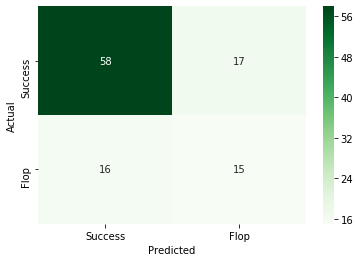

In [49]:
# Initiate Model
logistic_model = LogisticRegression(random_state = 0, class_weight = class_weights)
# Model Fitting on Training
logistic_model = logistic_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(logistic_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(logistic_model.predict_proba(x_test))

logistic_acc = metrics.accuracy_score(y_test, predicted)
logistic_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
logistic_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
logistic_confusion = metrics.confusion_matrix(y_test, predicted) 
logistic_class_report = metrics.classification_report(y_test, predicted)
logistic_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
logistic_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
logistic_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
logistic_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
logistic_cv_score = cross_val_score(logistic_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
logistic_cv_mean = np.mean(logistic_cv_score)
plot_confusion(y_test, predicted)

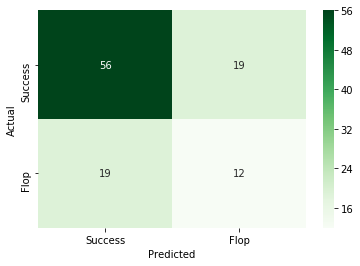

In [50]:
# Initiate Model
SGD_model = SGDClassifier(class_weight= class_weights, random_state= 1234)

# Model Fitting on Training
SGD_model = SGD_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(SGD_model.predict(x_test))
#probs = pd.DataFrame(SGD_model.predict_proba(x_test))

SGD_acc = metrics.accuracy_score(y_test, predicted) 
SGD_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
SGD_AUC_proba = metrics.roc_auc_score(y_test, predicted)       
SGD_confusion = metrics.confusion_matrix(y_test, predicted) 
SGD_class_report = metrics.classification_report(y_test, predicted)
SGD_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
SGD_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
SGD_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
SGD_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
SGD_cv_scores = cross_val_score(SGD_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
SGD_cv_mean = np.mean(SGD_cv_scores)
plot_confusion(y_test, predicted)

In [488]:
pd.DataFrame(search_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1473,1.147478,0.113867,0.004238,0.000199,0.2,14,140,"{'learning_rate': 0.2, 'max_depth': 14, 'n_est...",0.575000,0.691667,...,0.675000,0.625000,0.533333,0.691667,0.606101,0.606101,0.661804,0.628234,0.049321,1
1453,1.450731,0.201042,0.004887,0.000766,0.2,13,140,"{'learning_rate': 0.2, 'max_depth': 13, 'n_est...",0.575000,0.591667,...,0.700000,0.625000,0.533333,0.616667,0.627321,0.721485,0.687003,0.621081,0.062543,2
630,1.030960,0.192535,0.004774,0.000608,0.1,12,110,"{'learning_rate': 0.1, 'max_depth': 12, 'n_est...",0.575000,0.666667,...,0.741667,0.525000,0.658333,0.666667,0.529178,0.627321,0.610080,0.620824,0.063410,3
637,1.502111,0.175869,0.004639,0.000225,0.1,12,180,"{'learning_rate': 0.1, 'max_depth': 12, 'n_est...",0.616667,0.625000,...,0.658333,0.508333,0.675000,0.675000,0.550398,0.606101,0.704244,0.620241,0.057882,4
1479,1.681434,0.308923,0.005207,0.000801,0.2,14,200,"{'learning_rate': 0.2, 'max_depth': 14, 'n_est...",0.633333,0.650000,...,0.783333,0.633333,0.508333,0.608333,0.584881,0.571618,0.610080,0.619158,0.066589,5
1430,1.067549,0.083189,0.006228,0.004980,0.2,12,110,"{'learning_rate': 0.2, 'max_depth': 12, 'n_est...",0.633333,0.600000,...,0.700000,0.525000,0.533333,0.708333,0.683024,0.588859,0.627321,0.619087,0.060915,6
1013,1.026889,0.072196,0.004207,0.000159,0.15,11,140,"{'learning_rate': 0.15, 'max_depth': 11, 'n_es...",0.616667,0.600000,...,0.700000,0.466667,0.583333,0.691667,0.567639,0.588859,0.683024,0.618952,0.070435,7
1478,1.414078,0.194066,0.004512,0.000477,0.2,14,190,"{'learning_rate': 0.2, 'max_depth': 14, 'n_est...",0.591667,0.591667,...,0.800000,0.633333,0.491667,0.691667,0.567639,0.606101,0.631300,0.618837,0.077577,8
1476,1.326055,0.190073,0.004551,0.000441,0.2,14,170,"{'learning_rate': 0.2, 'max_depth': 14, 'n_est...",0.591667,0.675000,...,0.758333,0.566667,0.491667,0.625000,0.584881,0.606101,0.610080,0.618439,0.068431,9
1086,0.621285,0.064748,0.003886,0.000287,0.15,15,70,"{'learning_rate': 0.15, 'max_depth': 15, 'n_es...",0.658333,0.733333,...,0.641667,0.583333,0.516667,0.733333,0.602122,0.627321,0.614058,0.617683,0.079697,10


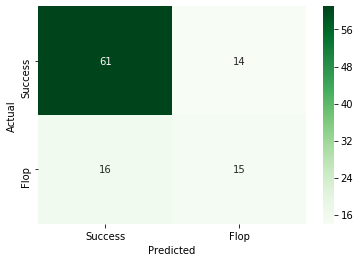

In [51]:
# Initiate Model

GBT_model = GradientBoostingClassifier(n_estimators=140, max_depth=14, learning_rate = 0.2, random_state = 1234)

# Model Fitting on Training
GBT_model = GBT_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(GBT_model.predict(x_test))
probs = pd.DataFrame(GBT_model.predict_proba(x_test))

GBT_acc = metrics.accuracy_score(y_test, predicted)
GBT_bal_acc = metrics.balanced_accuracy_score(y_test,predicted)
GBT_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
GBT_confusion = metrics.confusion_matrix(y_test, predicted) 
GBT_class_report = metrics.classification_report(y_test, predicted)
GBT_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
GBT_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
GBT_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
GBT_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
GBT_cv_scores = cross_val_score(GBT_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
GBT_cv_mean = np.mean(GBT_cv_scores)
#print(GBT_cv_mean)
plot_confusion(y_test, predicted)

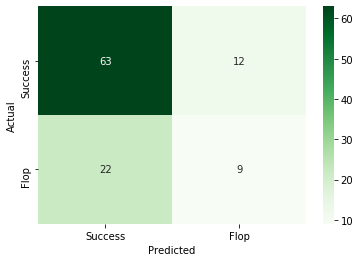

In [52]:
# Initiate Model
dtree_model = tree.DecisionTreeClassifier(max_depth=7, random_state = 1234) 

# Model Fitting on Training
dtree_model = dtree_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(dtree_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(dtree_model.predict_proba(x_test))

dtree_acc = metrics.accuracy_score(y_test, predicted) 
dtree_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
dtree_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
dtree_confusion = metrics.confusion_matrix(y_test, predicted) 
dtree_class_report = metrics.classification_report(y_test, predicted)
dtree_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
dtree_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
dtree_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
dtree_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
dtree_cv_score = cross_val_score(dtree_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
dtree_cv_mean = np.mean(dtree_cv_score)
plot_confusion(y_test, predicted)

In [593]:
# Initiate Model for GridSearchCV
random.seed(1234)

search_model =  RandomForestClassifier()

parameter_space = {
    'max_depth':  np.arange(1, 21),
    'bootstrap' : [True, False],
    'n_estimators': np.arange(10,210,10)
}

from sklearn.model_selection import GridSearchCV

search_cv = GridSearchCV(search_model, parameter_space, n_jobs=-1, cv=10, scoring = 'balanced_accuracy')
search_cv.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
             scoring='balanced_accuracy')

In [594]:
pd.DataFrame(search_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
744,0.118309,0.006599,0.009323,0.003246,False,18,50,"{'bootstrap': False, 'max_depth': 18, 'n_estim...",0.725000,0.633333,...,0.691667,0.633333,0.558333,0.666667,0.602122,0.567639,0.648541,0.621830,0.065429,1
765,0.144096,0.008771,0.009222,0.000491,False,19,60,"{'bootstrap': False, 'max_depth': 19, 'n_estim...",0.666667,0.641667,...,0.658333,0.575000,0.600000,0.650000,0.623342,0.567639,0.648541,0.618119,0.039842,2
763,0.102640,0.010755,0.008671,0.003161,False,19,40,"{'bootstrap': False, 'max_depth': 19, 'n_estim...",0.683333,0.600000,...,0.633333,0.633333,0.625000,0.708333,0.640584,0.529178,0.648541,0.616830,0.067448,3
796,0.396767,0.060706,0.020640,0.003084,False,20,170,"{'bootstrap': False, 'max_depth': 20, 'n_estim...",0.683333,0.616667,...,0.675000,0.616667,0.541667,0.691667,0.602122,0.529178,0.683024,0.616432,0.063062,4
714,0.328341,0.013212,0.017572,0.001407,False,16,150,"{'bootstrap': False, 'max_depth': 16, 'n_estim...",0.683333,0.658333,...,0.675000,0.591667,0.541667,0.650000,0.657825,0.546419,0.648541,0.615279,0.061791,5
788,0.210639,0.008692,0.013891,0.003267,False,20,90,"{'bootstrap': False, 'max_depth': 20, 'n_estim...",0.641667,0.658333,...,0.658333,0.616667,0.616667,0.708333,0.584881,0.529178,0.665782,0.614651,0.067850,6
764,0.116825,0.006501,0.008111,0.000413,False,19,50,"{'bootstrap': False, 'max_depth': 19, 'n_estim...",0.683333,0.658333,...,0.633333,0.616667,0.558333,0.666667,0.623342,0.507958,0.648541,0.614651,0.054446,6
751,0.267326,0.012757,0.016711,0.003668,False,18,120,"{'bootstrap': False, 'max_depth': 18, 'n_estim...",0.683333,0.641667,...,0.658333,0.675000,0.525000,0.650000,0.602122,0.529178,0.648541,0.613817,0.060766,8
701,0.050535,0.004204,0.005299,0.000289,False,16,20,"{'bootstrap': False, 'max_depth': 16, 'n_estim...",0.725000,0.641667,...,0.575000,0.641667,0.633333,0.650000,0.619363,0.529178,0.610080,0.612529,0.061038,9
723,0.103431,0.012747,0.007464,0.000556,False,17,40,"{'bootstrap': False, 'max_depth': 17, 'n_estim...",0.641667,0.641667,...,0.633333,0.600000,0.558333,0.666667,0.657825,0.529178,0.665782,0.611945,0.052582,10


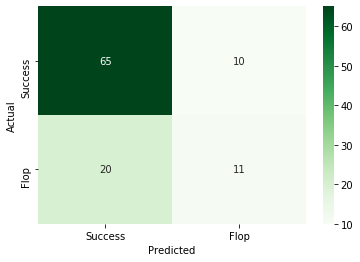

In [53]:
# Initiate Model
rf_model = RandomForestClassifier(random_state = 1234, bootstrap = False, max_depth = 18, n_estimators=50) 

# Model Fitting on Training
rf_model = rf_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(rf_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(rf_model.predict_proba(x_test))

rf_acc = metrics.accuracy_score(y_test, predicted)   
rf_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
rf_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
rf_confusion = metrics.confusion_matrix(y_test, predicted) 
rf_class_report = metrics.classification_report(y_test, predicted)
rf_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
rf_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(rf_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)
plot_confusion(y_test, predicted)

In [597]:
# Initiate Model for GridSearchCV
random.seed(1234)

search_model =  SVC()

parameter_space = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf']
}

from sklearn.model_selection import GridSearchCV

search_cv = GridSearchCV(search_model, parameter_space, n_jobs=-1, cv=10, scoring = 'balanced_accuracy')
search_cv.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='balanced_accuracy')

In [598]:
pd.DataFrame(search_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
15,0.012277,0.003867,0.003438,0.000255,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.583333,0.583333,...,0.566667,0.483333,0.65,0.5,0.576923,0.52122,0.576923,0.556673,0.046800,1
20,0.025102,0.010909,0.003596,0.000221,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.583333,0.566667,...,0.516667,0.466667,0.65,0.5,0.576923,0.52122,0.598143,0.550462,0.051418,2
0,0.010275,0.001388,0.004485,0.002857,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
13,0.010259,0.003709,0.003560,0.000379,10,0.001,rbf,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
23,0.015145,0.003635,0.003728,0.000348,1000,0.001,rbf,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
22,0.020009,0.005300,0.003656,0.000165,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
21,0.016014,0.004608,0.003673,0.000243,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
19,0.009575,0.003057,0.003629,0.000360,100,0.0001,rbf,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
18,0.009040,0.000636,0.003378,0.000172,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3
17,0.011589,0.003198,0.003451,0.000279,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.500000,0.500000,...,0.500000,0.500000,0.50,0.5,0.500000,0.50000,0.500000,0.500000,0.000000,3


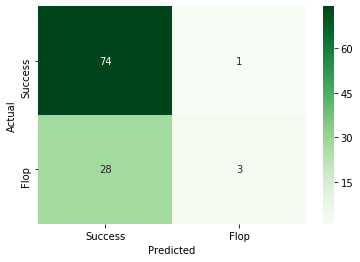

In [54]:
# Initiate Model

svm_class_model = SVC(C=100, gamma = 1, kernel = 'rbf', probability=True)

# Model Fitting on Training
svm_class_model = svm_class_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(svm_class_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(svm_class_model.predict_proba(x_test))

svm_class_acc = metrics.accuracy_score(y_test, predicted)
svm_class_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
svm_class_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
svm_class_confusion = metrics.confusion_matrix(y_test, predicted) 
svm_class_class_report = metrics.classification_report(y_test, predicted)
svm_class_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
svm_class_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
svm_class_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
svm_class_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
svm_class_cv_scores = cross_val_score(SVC(probability=True), x_train, y_train, scoring='balanced_accuracy', cv=10)
svm_class_cv_mean = np.mean(svm_class_cv_scores)
plot_confusion(y_test, predicted)

In [600]:
# Initiate Model for GridSearchCV
random.seed(1234)

search_model =  KNeighborsClassifier()

parameter_space = {
    'leaf_size':  np.arange(1, 51),
    'n_neighbors' : np.arange(1, 31),
    'p': [1,2]
}

from sklearn.model_selection import GridSearchCV

search_cv = GridSearchCV(search_model, parameter_space, n_jobs=-1, cv=10, scoring = 'balanced_accuracy')
search_cv.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'p': [1, 2]},
             scoring='balanced_accuracy')

In [601]:
pd.DataFrame(search_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
65,0.007913,0.002921,0.007452,0.003701,2,3,2,"{'leaf_size': 2, 'n_neighbors': 3, 'p': 2}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
2164,0.005863,0.000568,0.006027,0.002413,37,3,1,"{'leaf_size': 37, 'n_neighbors': 3, 'p': 1}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
844,0.006292,0.002031,0.005233,0.000662,15,3,1,"{'leaf_size': 15, 'n_neighbors': 3, 'p': 1}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
1684,0.006223,0.001784,0.005223,0.000736,29,3,1,"{'leaf_size': 29, 'n_neighbors': 3, 'p': 1}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
1685,0.005554,0.000096,0.005432,0.001209,29,3,2,"{'leaf_size': 29, 'n_neighbors': 3, 'p': 2}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
1744,0.006144,0.001279,0.004985,0.000183,30,3,1,"{'leaf_size': 30, 'n_neighbors': 3, 'p': 1}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
1745,0.005997,0.000489,0.005156,0.000197,30,3,2,"{'leaf_size': 30, 'n_neighbors': 3, 'p': 2}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
785,0.005527,0.000068,0.004913,0.000051,14,3,2,"{'leaf_size': 14, 'n_neighbors': 3, 'p': 2}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
784,0.006205,0.001287,0.005417,0.001294,14,3,1,"{'leaf_size': 14, 'n_neighbors': 3, 'p': 1}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1
1804,0.006389,0.001194,0.005774,0.001084,31,3,1,"{'leaf_size': 31, 'n_neighbors': 3, 'p': 1}",0.75,0.666667,...,0.6,0.666667,0.683333,0.541667,0.602122,0.606101,0.683024,0.651625,0.059692,1


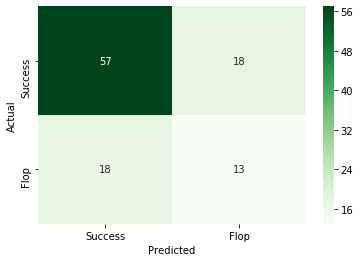

In [55]:
# Initiate Model
knn_model = KNeighborsClassifier(n_neighbors=3, leaf_size = 2, p = 2)

# Model Fitting on Training
knn_model.fit(x_train, y_train)

# Test set predictions
predicted = pd.DataFrame(knn_model.predict(x_test))
# Test set prediction probabilities
probs = pd.DataFrame(knn_model.predict_proba(x_test))

knn_acc = metrics.accuracy_score(y_test, predicted)
knn_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
knn_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
knn_confusion = metrics.confusion_matrix(y_test, predicted) 
knn_class_report = metrics.classification_report(y_test, predicted)
knn_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
knn_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(knn_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_mean
plot_confusion(y_test, predicted)

In [609]:
# Initiate Model for GridSearchCV
random.seed(1234)

search_model =  MLPClassifier()

parameter_space = {
    'hidden_layer_sizes': np.arange(1,25),
    'activation': ['relu','identity','logistic','tanh'],
    'max_iter' : [100,200],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.005, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

search_cv = GridSearchCV(search_model, parameter_space, n_jobs=-1, cv=10, scoring = 'balanced_accuracy')
search_cv.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'logistic', 'tanh'],
                         'alpha': [0.005, 0.01, 0.05],
                         'hidden_layer_sizes': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200],
                         'solver': ['sgd', 'adam', 'lbfgs']},
             scoring='balanced_accuracy')

In [610]:
pd.DataFrame(search_cv.cv_results_).sort_values('mean_test_score', ascending = False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2825,0.175403,0.013138,0.003387,0.000135,tanh,0.005,20,constant,200,lbfgs,...,0.525000,0.466667,0.691667,0.633333,0.615385,0.559682,0.619363,0.592776,0.059202,1
2783,0.164456,0.015724,0.003379,0.000107,tanh,0.005,16,adaptive,200,lbfgs,...,0.525000,0.466667,0.658333,0.633333,0.598143,0.559682,0.619363,0.587719,0.053693,2
2687,0.132596,0.007054,0.003806,0.001239,tanh,0.005,8,adaptive,200,lbfgs,...,0.500000,0.508333,0.691667,0.550000,0.615385,0.559682,0.619363,0.586110,0.054800,3
2819,0.174116,0.006983,0.003362,0.000129,tanh,0.005,19,adaptive,200,lbfgs,...,0.525000,0.466667,0.691667,0.550000,0.615385,0.559682,0.619363,0.584443,0.058770,4
2837,0.183964,0.013017,0.003411,0.000175,tanh,0.005,21,constant,200,lbfgs,...,0.483333,0.450000,0.691667,0.591667,0.615385,0.559682,0.619363,0.584443,0.067565,4
2771,0.160957,0.007496,0.003431,0.000141,tanh,0.005,15,adaptive,200,lbfgs,...,0.483333,0.450000,0.691667,0.591667,0.615385,0.559682,0.619363,0.582776,0.066536,6
2879,0.199330,0.012631,0.003558,0.000238,tanh,0.005,24,adaptive,200,lbfgs,...,0.483333,0.466667,0.733333,0.508333,0.615385,0.559682,0.619363,0.581110,0.076867,7
2663,0.120920,0.005571,0.003368,0.000145,tanh,0.005,6,adaptive,200,lbfgs,...,0.483333,0.450000,0.691667,0.633333,0.598143,0.559682,0.619363,0.581052,0.066935,8
2684,0.071470,0.006334,0.003418,0.000179,tanh,0.005,8,adaptive,100,lbfgs,...,0.516667,0.466667,0.691667,0.550000,0.615385,0.559682,0.619363,0.579443,0.059241,9
2735,0.147822,0.013732,0.003404,0.000152,tanh,0.005,12,adaptive,200,lbfgs,...,0.483333,0.450000,0.691667,0.591667,0.615385,0.559682,0.619363,0.579443,0.065583,9


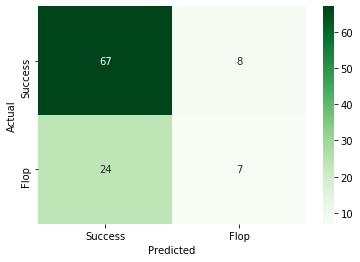

In [55]:

# Instantiate
mlp_model = MLPClassifier(hidden_layer_sizes=(20), activation = 'tanh', alpha = 0.005, learning_rate = 'constant', max_iter = 200, solver = 'lbfgs', random_state = 1234)
# Fit the model
mlp_model.fit(x_train, y_train)
# Accuracy
mlp_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(mlp_model.predict(x_test))
probs = pd.DataFrame(mlp_model.predict_proba(x_test))

mlp_acc = metrics.accuracy_score(y_test, predicted)
mlp_bal_acc = metrics.balanced_accuracy_score(y_test, predicted)
mlp_AUC_proba = metrics.roc_auc_score(y_test, probs[1])       
mlp_confusion = metrics.confusion_matrix(y_test, predicted) 
mlp_class_report = metrics.classification_report(y_test, predicted)
mlp_precision_score = metrics.precision_score(y_test, predicted, pos_label=1)
mlp_recall_score = metrics.recall_score(y_test, predicted, pos_label=1)
mlp_f1_score = metrics.f1_score(y_test, predicted, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
mlp_AUC = metrics.auc(fpr, tpr)

# Evaluate the model using 10-fold cross-validation
mlp_cv_scores = cross_val_score(mlp_model, x_train, y_train, scoring='balanced_accuracy', cv=10)
mlp_cv_mean = np.mean(mlp_cv_scores)
plot_confusion(y_test, predicted)

In [56]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'd.Tree', 'r.f.', 'SVM', 'kNN',  'MLP', 'SGD', 'GBT'],
  'Accuracy' : [logistic_acc, dtree_acc, rf_acc, svm_class_acc, knn_acc, mlp_acc, SGD_acc, GBT_acc],
  'AUC' : [logistic_AUC, dtree_AUC, rf_AUC, svm_class_AUC, knn_AUC, mlp_AUC, SGD_AUC, GBT_AUC],
  'Precision': [logistic_precision_score, dtree_precision_score, rf_precision_score, svm_class_precision_score, knn_precision_score, mlp_precision_score, SGD_precision_score, GBT_precision_score],
  'recall' : [logistic_recall_score, dtree_recall_score, rf_recall_score, svm_class_recall_score, knn_recall_score, mlp_recall_score, SGD_recall_score, GBT_recall_score],
  'F1' : [logistic_f1_score, dtree_f1_score, rf_f1_score, svm_class_f1_score, knn_f1_score, mlp_f1_score, SGD_f1_score, GBT_f1_score],
  'cv_AUC' : [logistic_cv_mean, dtree_cv_mean, rf_cv_mean, svm_class_cv_mean, knn_cv_mean, mlp_cv_mean, SGD_cv_mean, GBT_cv_mean]
})
# Print table and sort by test precision
models.sort_values(by='cv_AUC', ascending=False)

,Model,Accuracy,AUC,Precision,recall,F1,cv_AUC
4,kNN,0.660377,0.589677,0.419355,0.419355,0.419355,0.651625
7,GBT,0.716981,0.648602,0.517241,0.483871,0.500000,0.609613
2,r.f.,0.716981,0.610753,0.523810,0.354839,0.423077,0.599138
1,d.Tree,0.679245,0.565161,0.428571,0.290323,0.346154,0.564553
0,Logistic,0.688679,0.628602,0.468750,0.483871,0.476190,0.563890
6,SGD,0.641509,0.566882,0.387097,0.387097,0.387097,0.517065
3,SVM,0.726415,0.541720,0.750000,0.096774,0.171429,0.500000
5,MLP,0.707547,0.500000,0.000000,0.000000,0.000000,0.500000


## Partial Dependency Plots

Computing partial dependence plots...
done in 2.040s


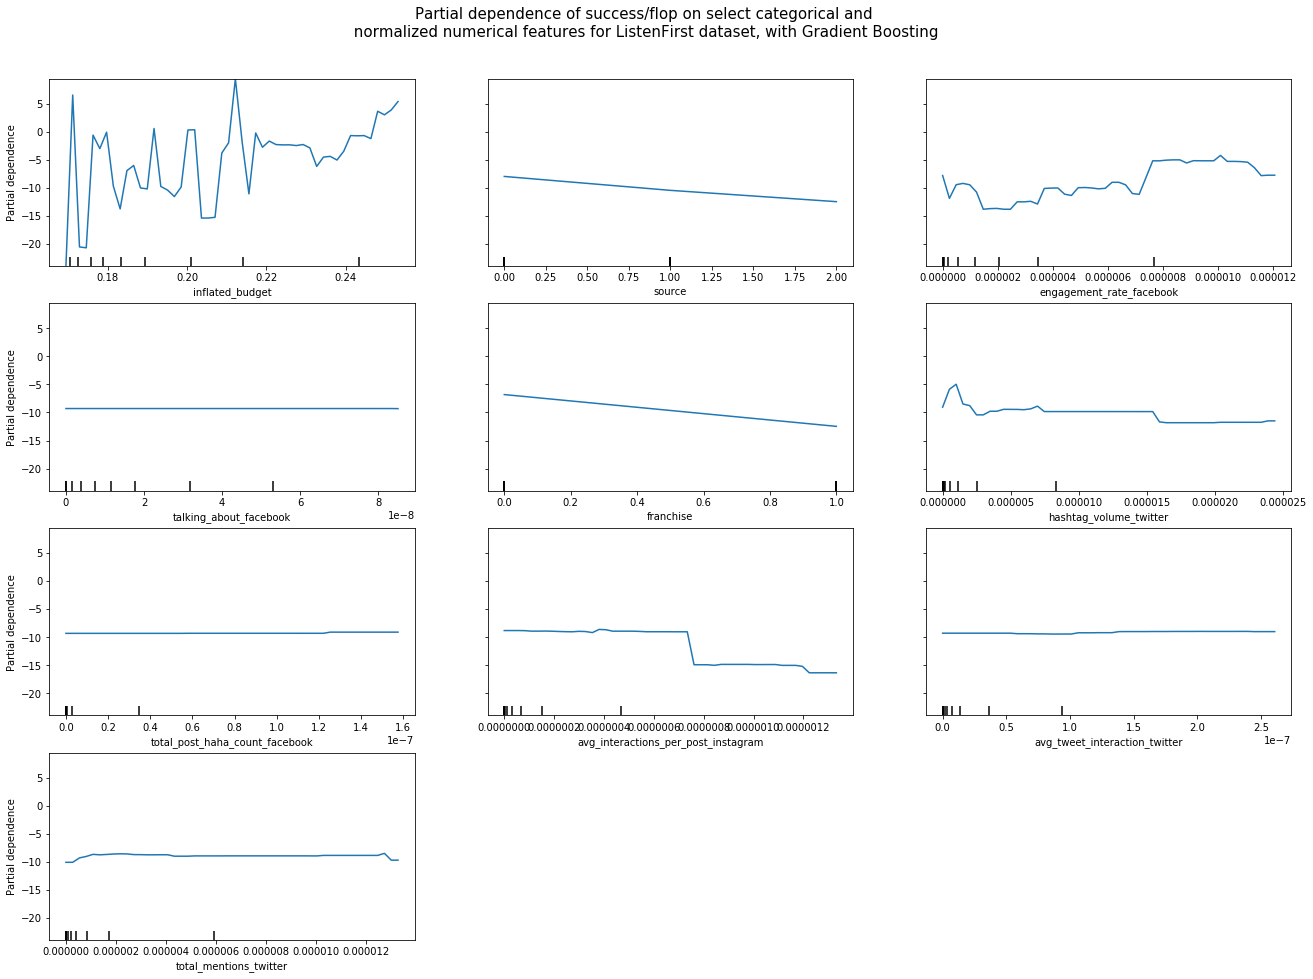

In [57]:
from time import time

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


print('Computing partial dependence plots...')

tic = time()
names = ['inflated_budget', 'source',
            'engagement_rate_facebook',  'talking_about_facebook',
                           'franchise',  'hashtag_volume_twitter',
      'total_post_haha_count_facebook', 'avg_interactions_per_post_instagram',
       'avg_tweet_interaction_twitter', 'total_mentions_twitter' ]

features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            
plot_partial_dependence(GBT_model, x_train, features, feature_names=names,n_jobs=-1, grid_resolution=50)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()

fig.suptitle('Partial dependence of success/flop on select categorical and\n'
             ' normalized numerical features for ListenFirst dataset, with Gradient Boosting',
             x=1.5, y=3.25, verticalalignment='top', fontsize = 15)

plt.subplots_adjust(bottom=0.01, right=3, top=3)  # tight_layout causes overlap with suptit
